In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import random
from tempfile import mkdtemp
from sklearn.pipeline import Pipeline

In [2]:
df_sp = pd.read_csv("../../data/spicata_clean_500.csv")
df_sp.head()

C:\Users\lisa_\AppData\Local\Temp\ipykernel_49448\4074931185.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sp = pd.read_csv("../../data/spicata_clean_500.csv")


,Unnamed: 0,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,...,species_guess,scientific_name,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff
0,0,156253,1990-09-01 20:20:16,1990-09-01,1990-09-02 00:20:16+00:00,Eastern Time (US & Canada),317,2012-12-03 02:52:30+00:00,research,http://www.inaturalist.org/observations/156253,...,Cururu Toad,Rhinella diptycha,Cururu Toad,Animalia,Rhinella,Rhinella diptycha,0,0,-1.000000e-03,-0.001000
1,1,99704839,Fri May 20 1994 09:37:00 GMT-0400 (EDT),1994-05-20,1994-05-20 13:37:00+00:00,Eastern Time (US & Canada),317,2021-10-29 13:45:37+00:00,research,https://www.inaturalist.org/observations/99704839,...,Brown-headed Cowbird,Molothrus ater,Brown-headed Cowbird,Animalia,Molothrus,Molothrus ater,0,0,1.953437e+06,7492.228775
2,2,99705133,Fri May 20 1994 09:37:00 GMT-0400 (EDT),1994-05-20,1994-05-20 13:37:00+00:00,Eastern Time (US & Canada),317,2021-10-29 13:49:59+00:00,research,https://www.inaturalist.org/observations/99705133,...,Northern Cardinal,Cardinalis cardinalis,Northern Cardinal,Animalia,Cardinalis,Cardinalis cardinalis,0,0,0.000000e+00,0.000000
3,3,160735,Thu May 20 1994 15:27:35 GMT-0400 (EDT),1994-05-20,1994-05-20 19:27:35+00:00,Eastern Time (US & Canada),317,2012-12-11 20:23:37+00:00,research,http://www.inaturalist.org/observations/160735,...,Brown-headed Cowbird,Molothrus ater,Brown-headed Cowbird,Animalia,Molothrus,Molothrus ater,0,0,3.505833e+02,0.472500
4,4,36335283,Wed Jul 28 1999 08:24:34 GMT-0400 (EDT),1999-07-28,1999-07-28 12:24:34+00:00,Eastern Time (US & Canada),317,2019-12-04 01:50:03+00:00,research,https://www.inaturalist.org/observations/36335283,...,American Red Squirrel,Tamiasciurus hudsonicus,American Red Squirrel,Animalia,Tamiasciurus,Tamiasciurus hudsonicus,0,0,2.728377e+06,56.747939


In [3]:
# drop repeat index column
df_sp.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
# convert time objects to UTC datetimes
df_sp["time_observed_at"] = pd.to_datetime(df_sp["time_observed_at"], utc = True)
df_sp["created_at"] = pd.to_datetime(df_sp["created_at"], utc = True)

In [5]:
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050151 entries, 0 to 1050150
Data columns (total 29 columns):
 #   Column                            Non-Null Count    Dtype              
---  ------                            --------------    -----              
 0   id                                1050151 non-null  int64              
 1   observed_on_string                1050151 non-null  object             
 2   observed_on                       1050151 non-null  object             
 3   time_observed_at                  1050151 non-null  datetime64[ns, UTC]
 4   time_zone                         1050151 non-null  object             
 5   user_id                           1050151 non-null  int64              
 6   created_at                        1050151 non-null  datetime64[ns, UTC]
 7   quality_grade                     1050151 non-null  object             
 8   url                               1050151 non-null  object             
 9   image_url                         1

## Columns for Analyzing Datetimes

Datetimes don't work for models and many graphs. There are boundless ways to engineer the datetime for EDA and later modeling. For now, I am choosing two options:
1) Continuous: "time passed since" -- I am choosing the earliest time that occurs in the dataset (minimum value of "time_observed_at", setting it to zero and measuring the other times in minutes since that earliest time
2) Discrete values: Breaking the "time_observed_at" and "created_at" dates into a column for each of its discrete integer parts: Year, Month, Day, Hour (leaving out minutes, especially because I already have a column engineered from the original EDA that measures each observation for a user in minutes since their last observation)

### Continuous time columns -- "minutes since"

In [6]:
# Creates a column ("obs_time_conv_(minutes)") that measures all observation times in minutes 
#that have passed since first observation of dataset

min_time = df_sp["time_observed_at"].min() # finds first time_observed for dataset
time_since = df_sp["time_observed_at"] - min_time #calcs diff between time_observed for row and first time
time_obs_conv = round((time_since.dt.total_seconds()) / 60 , 2) # converts diff to minutes
df_sp.loc[:, "obs_time_conv_(minutes)"] = time_obs_conv # stores values in a new column

df_sp.sample(3) #sanity check


,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,image_url,...,scientific_name,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff,obs_time_conv_(minutes)
899490,51109558,Sat Jun 27 2020 12:11:40 GMT-0400 (EDT),2020-06-27,2020-06-27 16:11:40+00:00,Eastern Time (US & Canada),2585152,2020-06-27 16:18:45+00:00,needs_id,https://www.inaturalist.org/observations/51109558,https://inaturalist-open-data.s3.amazonaws.com...,...,Lysimachia ciliata,fringed loosestrife,Plantae,Lysimachia,Lysimachia ciliata,0,0,13.733333,0.11040,39906313.67
650122,18637220,2009/04/16 10:19 AM EDT,2009-04-16,2009-04-16 14:19:00+00:00,Eastern Time (US & Canada),777160,2018-11-25 23:51:41+00:00,research,https://www.inaturalist.org/observations/18637220,https://static.inaturalist.org/photos/28527532...,...,Megisto cymela viola,Viola's Wood-Satyr,Animalia,Megisto,Megisto cymela,0,0,6.000000,0.00000,34016601.00
791298,124262071,2022-07-01 09:31:24-05:00,2022-07-01,2022-07-01 14:31:24+00:00,Central Time (US & Canada),1269999,2022-07-01 16:22:26+00:00,research,https://www.inaturalist.org/observations/12426...,https://inaturalist-open-data.s3.amazonaws.com...,...,Xylocopa virginica,Eastern Carpenter Bee,Animalia,Xylocopa,Xylocopa virginica,0,0,0.250000,0.00449,40963173.40


In [7]:
# Creates a column ("created_at_conv_(minutes)") that measures all "created_at" times in minutes 
# that have passed since first observation of dataset

# uses "min_time" from above--all still measured from first observation time, otherwise same code 
time_since = df_sp["created_at"] - min_time 
created_at_conv = round((time_since.dt.total_seconds()) / 60 , 2) 
df_sp.loc[:, "created_at_conv_(minutes)"] = created_at_conv
df_sp.sample(3)

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,image_url,...,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff,obs_time_conv_(minutes),created_at_conv_(minutes)
100847,15167646,2018-08-05 9:56 AM CDT,2018-08-05,2018-08-05 14:56:00+00:00,Central Time (US & Canada),18446,2018-08-06 13:49:34+00:00,needs_id,https://www.inaturalist.org/observations/15167646,https://inaturalist-open-data.s3.amazonaws.com...,...,not stated,Animalia,Efferia,not stated,0,0,5.0,0.000000,38909758.00,38911131.57
406445,29093810,2019/07/03 10:34 PM CDT,2019-07-03,2019-07-04 03:34:00+00:00,Central Time (US & Canada),375183,2019-07-19 01:36:22+00:00,needs_id,https://www.inaturalist.org/observations/29093810,https://inaturalist-open-data.s3.amazonaws.com...,...,not stated,Animalia,not stated,not stated,0,0,3.0,0.000000,39388596.00,39410078.37
262647,147976360,2023-02-03 11:01:11-08:00,2023-02-03,2023-02-03 19:01:11+00:00,Pacific Time (US & Canada),150454,2023-02-03 21:53:54+00:00,needs_id,https://www.inaturalist.org/observations/14797...,https://inaturalist-open-data.s3.amazonaws.com...,...,Annual Cryptanthas,Plantae,Cryptantha,not stated,0,0,2.0,0.130907,41275923.18,41276095.90


### Discrete time columns -- Year, Month, Day and Hour

The code to create these on the whole dataset is timely. My initial exploratory analysis focuses on one (randomly chosen) user, so I will create that slice of the data first and then apply this to save time.

In [8]:
random_user = 923056
rand_user_df = df_sp[df_sp["user_id"] == random_user]
rand_user_df.reset_index(inplace = True, drop = True)
rand_user_df.sample(3)

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,image_url,...,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff,obs_time_conv_(minutes),created_at_conv_(minutes)
150,33787052,Wed Oct 02 2019 16:28:51 GMT-0700 (PDT),2019-10-02,2019-10-02 23:28:51+00:00,Pacific Time (US & Canada),923056,2019-10-03 05:55:19+00:00,needs_id,https://www.inaturalist.org/observations/33787052,https://static.inaturalist.org/photos/53103176...,...,panicled willowherb,Plantae,Epilobium,Epilobium brachycarpum,0,0,1.05,0.069715,39519390.85,39519777.32
13,26642480,Thu Apr 11 2019 14:36:06 GMT-0400 (EDT),2019-04-11,2019-04-11 18:36:06+00:00,Eastern Time (US & Canada),923056,2019-06-09 00:02:06+00:00,research,https://www.inaturalist.org/observations/26642480,https://static.inaturalist.org/photos/41381594...,...,Eastern Dobsonfly,Animalia,Corydalus,Corydalus cornutus,0,0,20128.05,14.919535,39268538.10,39352384.10
2,11784631,Sun Apr 29 2018 16:09:45 GMT-0400 (EDT),2018-04-29,2018-04-29 20:09:45+00:00,Eastern Time (US & Canada),923056,2018-04-29 20:10:42+00:00,needs_id,https://www.inaturalist.org/observations/11784631,https://static.inaturalist.org/photos/16855097...,...,black cherry,Plantae,Prunus,Prunus serotina,0,0,124.40,2.224172,38768951.75,38768952.70


In [9]:
rand_user_df.shape[0]

225

In [10]:
for i in range(rand_user_df.shape[0]):
    rand_user_df.loc[i, "obs_year"] = int(rand_user_df["time_observed_at"].dt.strftime('%Y')[i])
    rand_user_df.loc[i, "obs_month"] = int(rand_user_df["time_observed_at"].dt.strftime('%M')[i])
    rand_user_df.loc[i, "obs_day"] = int(rand_user_df["time_observed_at"].dt.strftime('%D')[i][3:5])
    rand_user_df.loc[i, "obs_hour"] = int(rand_user_df["time_observed_at"].dt.strftime('%H')[i])
    
    rand_user_df.loc[i, "created_year"] = int(rand_user_df["created_at"].dt.strftime('%Y')[i])
    rand_user_df.loc[i, "created_month"] = int(rand_user_df["created_at"].dt.strftime('%M')[i])
    rand_user_df.loc[i, "created_day"] = int(rand_user_df["created_at"].dt.strftime('%D')[i][3:5])
    rand_user_df.loc[i, "created_hour"] = int(rand_user_df["created_at"].dt.strftime('%H')[i])

rand_user_df.sample(3)

C:\Users\lisa_\AppData\Local\Temp\ipykernel_49448\1751017318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_user_df.loc[i, "obs_year"] = int(rand_user_df["time_observed_at"].dt.strftime('%Y')[i])
C:\Users\lisa_\AppData\Local\Temp\ipykernel_49448\1751017318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_user_df.loc[i, "obs_month"] = int(rand_user_df["time_observed_at"].dt.strftime('%M')[i])
C:\Users\lisa_\AppData\Local\Temp\ipykernel_49448\1751017318.py:4: SettingWithCopyWarning: 
A value

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,image_url,...,obs_time_conv_(minutes),created_at_conv_(minutes),obs_year,obs_month,obs_day,obs_hour,created_year,created_month,created_day,created_hour
220,178746560,2023-08-16 14:11:33-07:00,2023-08-16,2023-08-16 21:11:33+00:00,Pacific Time (US & Canada),923056,2023-08-16 21:14:32+00:00,needs_id,https://www.inaturalist.org/observations/17874...,https://static.inaturalist.org/photos/31418515...,...,41555413.55,41555416.53,2023.0,11.0,16.0,21.0,2023.0,14.0,16.0,21.0
40,27841791,Fri Jun 28 2019 20:06:11 GMT-0400 (EDT),2019-06-28,2019-06-29 00:06:11+00:00,Eastern Time (US & Canada),923056,2019-06-29 00:08:03+00:00,needs_id,https://www.inaturalist.org/observations/27841791,https://static.inaturalist.org/photos/43752570...,...,39381188.18,39381190.05,2019.0,6.0,29.0,0.0,2019.0,8.0,29.0,0.0
216,170191093,2023-06-29 16:07:39-06:00,2023-06-29,2023-06-29 22:07:39+00:00,Mountain Time (US & Canada),923056,2023-06-29 22:54:08+00:00,needs_id,https://www.inaturalist.org/observations/17019...,https://static.inaturalist.org/photos/29514841...,...,41486349.65,41486396.13,2023.0,7.0,29.0,22.0,2023.0,54.0,29.0,22.0


## Bivariate EDA on Random_User

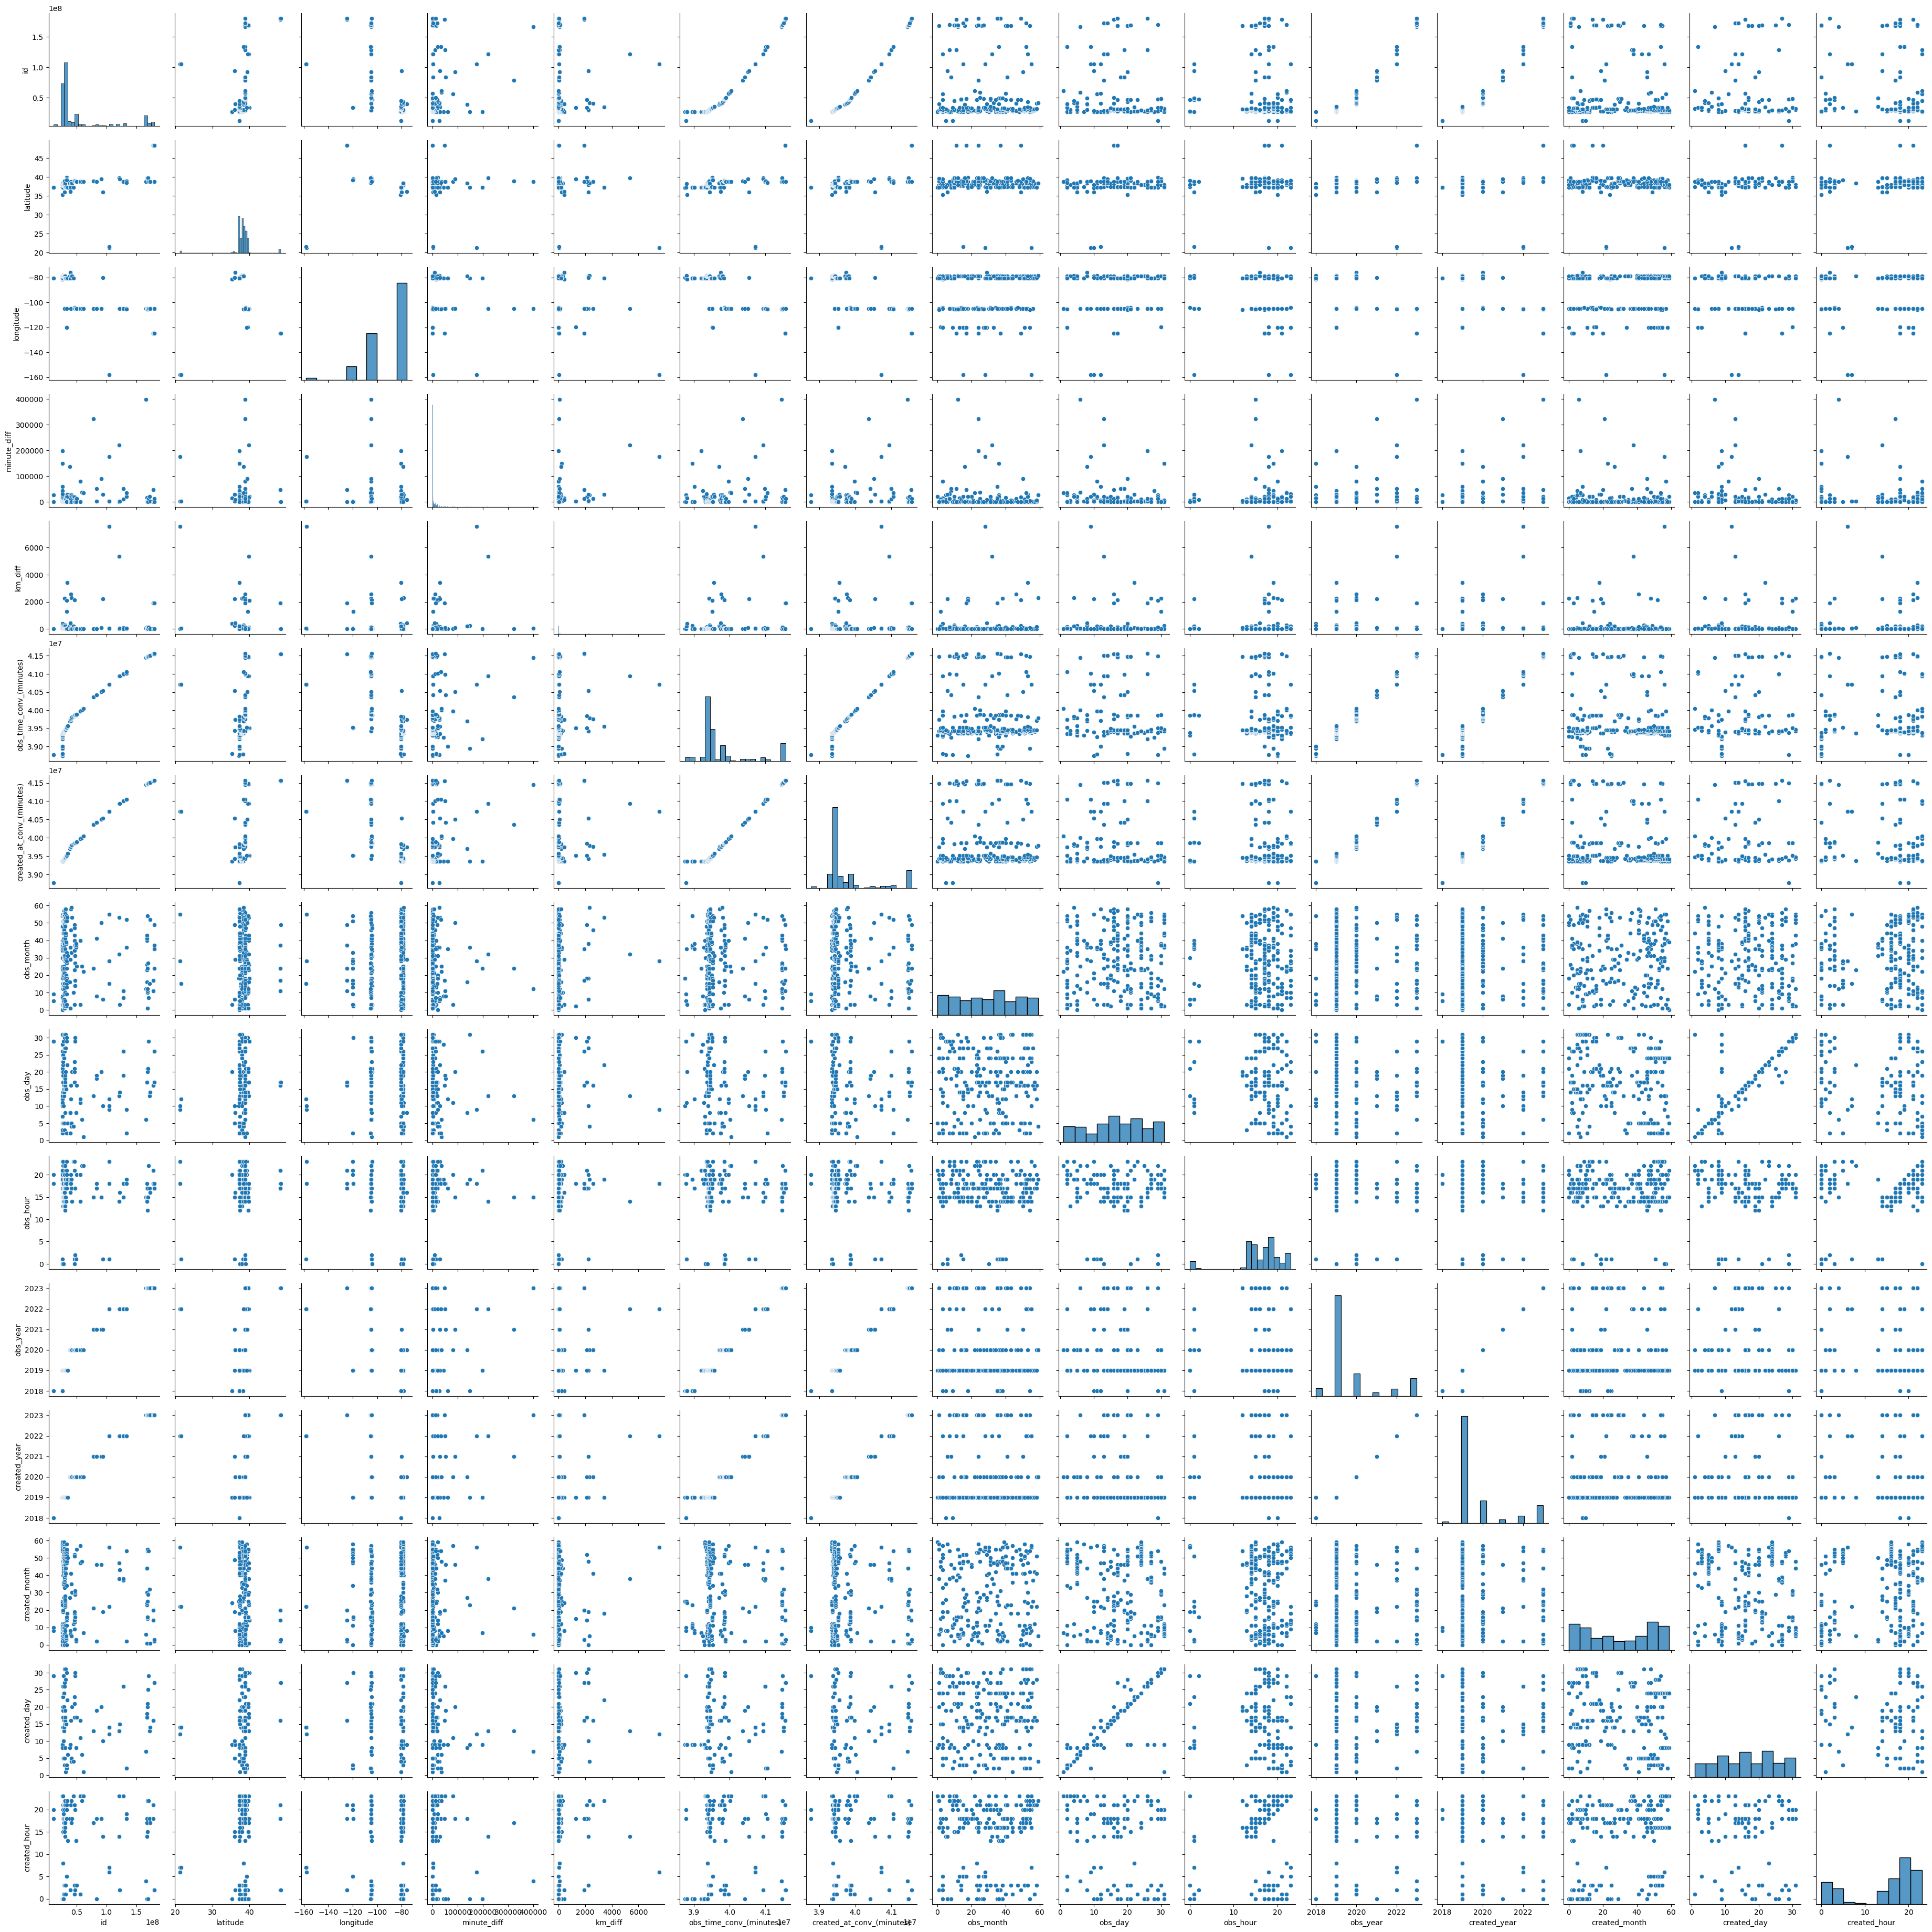

In [11]:
# choosing the columns I'm targeting for identifying geo/time clusters for "hikes"
pairplot_df = rand_user_df[['id', 'latitude',
       'longitude', 'minute_diff', 'km_diff',
       'obs_time_conv_(minutes)', 'created_at_conv_(minutes)', 'obs_month', 'obs_day', 'obs_hour', 'obs_year',
       'created_year', 'created_month', 'created_day', 'created_hour']]

sns.pairplot(pairplot_df)





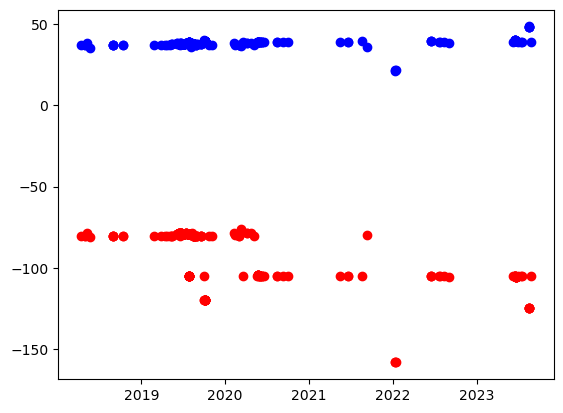

In [12]:
plt.figure()
plt.scatter(rand_user_df["time_observed_at"], rand_user_df["longitude"], c = 'red')
plt.scatter(rand_user_df["time_observed_at"], rand_user_df["latitude"], c = 'blue')
plt.show()

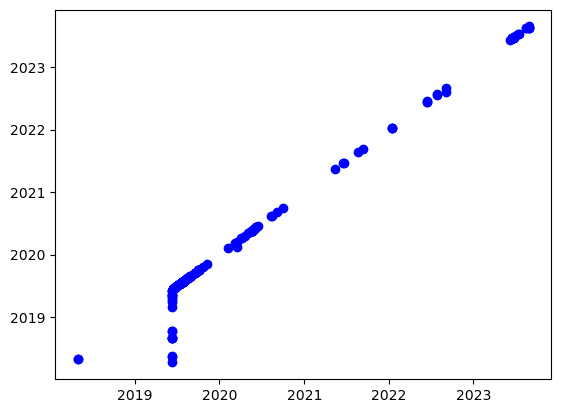

In [13]:
plt.figure()
plt.scatter(rand_user_df["created_at"], rand_user_df["time_observed_at"], c = 'blue')
plt.show()

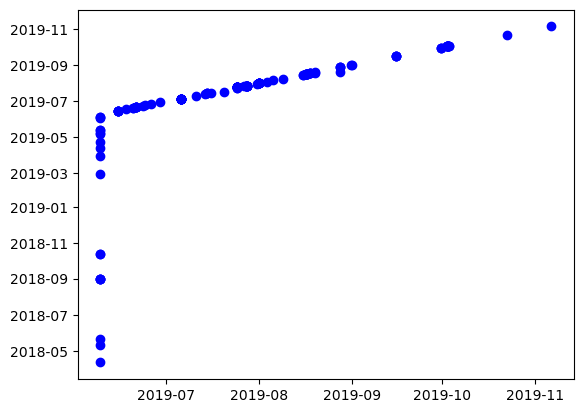

In [14]:
closer_look = rand_user_df[rand_user_df["created_at"].dt.strftime('%Y') == '2019']
plt.figure()
plt.scatter(closer_look["created_at"], closer_look["time_observed_at"], c = 'blue')
plt.show()

In [15]:
closer_look.head()

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,image_url,...,obs_time_conv_(minutes),created_at_conv_(minutes),obs_year,obs_month,obs_day,obs_hour,created_year,created_month,created_day,created_hour
0,26643807,Tue Apr 10 2018 16:18:13 GMT-0400 (EDT),2018-04-10,2018-04-10 20:18:13+00:00,Eastern Time (US & Canada),923056,2019-06-09 00:25:55+00:00,research,https://www.inaturalist.org/observations/26643807,https://static.inaturalist.org/photos/41383609...,...,38741600.22,39352407.92,2018.0,18.0,10.0,20.0,2019.0,25.0,9.0,0.0
3,26643745,Thu May 10 2018 21:35:19 GMT-0400 (EDT),2018-05-10,2018-05-11 01:35:19+00:00,Eastern Time (US & Canada),923056,2019-06-09 00:25:08+00:00,research,https://www.inaturalist.org/observations/26643745,https://static.inaturalist.org/photos/41383540...,...,38785117.32,39352407.13,2018.0,35.0,11.0,1.0,2019.0,25.0,9.0,0.0
4,26643675,Sun May 20 2018 16:03:39 GMT-0400 (EDT),2018-05-20,2018-05-20 20:03:39+00:00,Eastern Time (US & Canada),923056,2019-06-09 00:24:27+00:00,research,https://www.inaturalist.org/observations/26643675,https://static.inaturalist.org/photos/41383503...,...,38799185.65,39352406.45,2018.0,3.0,20.0,20.0,2019.0,24.0,9.0,0.0
5,26643587,Fri Aug 31 2018 15:36:32 GMT-0400 (EDT),2018-08-31,2018-08-31 19:36:32+00:00,Eastern Time (US & Canada),923056,2019-06-09 00:23:04+00:00,needs_id,https://www.inaturalist.org/observations/26643587,https://static.inaturalist.org/photos/41383396...,...,38947478.53,39352405.07,2018.0,36.0,31.0,19.0,2019.0,23.0,9.0,0.0
6,26643040,Fri Aug 31 2018 15:37:17 GMT-0400 (EDT),2018-08-31,2018-08-31 19:37:17+00:00,Eastern Time (US & Canada),923056,2019-06-09 00:12:17+00:00,research,https://www.inaturalist.org/observations/26643040,https://static.inaturalist.org/photos/41382442...,...,38947479.28,39352394.28,2018.0,37.0,31.0,19.0,2019.0,12.0,9.0,0.0


In [16]:
(rand_user_df["created_at"].dt.strftime('%D') == '06/09/19').sum()

13

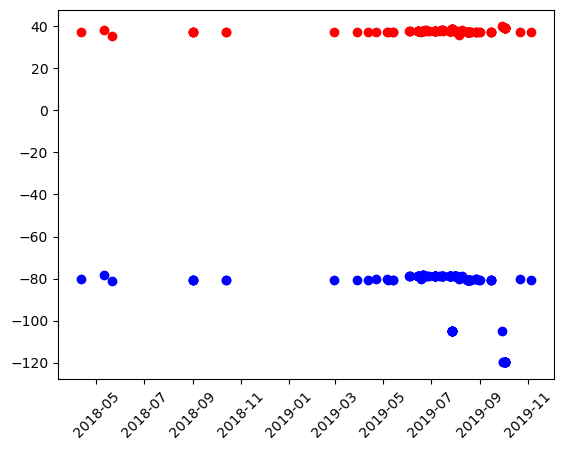

In [17]:
plt.figure()
plt.scatter(closer_look["time_observed_at"], closer_look["latitude"], c = 'red')
plt.scatter(closer_look["time_observed_at"], closer_look["longitude"], c = 'blue')
plt.xticks(rotation = 45)
plt.show()

# Modeling -- Initial Exploration

## What can I find by just grouping by date?

Before trying complicated algorithms, a simple data analytics approach might choose to groupby date of observation time to approximate a "hike". I'll create clusters using this technique first and then compare to what emerges when I use clustering models.

In [18]:
# Use the date of time_observated_at to group and count rows
# Look at top 20 values when sorted lowest to highest
potential_hikes = rand_user_df["time_observed_at"].dt.strftime('%D').value_counts().sort_values().tail(20)
potential_hikes

08/17/23     3
06/08/20     3
08/27/19     3
06/20/23     3
07/14/19     3
08/17/19     4
05/30/20     4
08/31/18     4
09/15/19     4
06/17/23     6
06/20/19     6
06/21/23     6
05/20/20     6
06/14/19     6
07/31/19     9
08/16/19    10
07/27/19    11
10/02/19    12
07/05/19    14
07/24/19    21
Name: time_observed_at, dtype: int64

If I use 5 as a minimum for grouping, there are 11 "groups" here that might represent single hikes. Or 5 groups if I choose 10 or more as a grouping standard. 

In [19]:
# making an array of the dates with at least as many observations as the min_samples specified

min_samples = 10 # using same terminology as DBSCAN
top_dates = potential_hikes[potential_hikes.values >= min_samples].index
top_dates

Index(['08/16/19', '07/27/19', '10/02/19', '07/05/19', '07/24/19'], dtype='object')

In [20]:
# creating dictionary that will assign an integer to each cluster

artificial_cluster = {}
i = 0
for day in top_dates:
    artificial_cluster[day] = i
    i += 1
artificial_cluster
    

{'08/16/19': 0, '07/27/19': 1, '10/02/19': 2, '07/05/19': 3, '07/24/19': 4}

In [21]:
# Adding a cluster column to the dataframe

for i in range(rand_user_df.shape[0]):
    # if observated date is in the top_dates, array, the new column will be filled with the corresponding cluster number
    if rand_user_df.loc[i, "time_observed_at"].strftime('%D') in top_dates:
        rand_user_df.loc[i, "Artif_Cluster"] = artificial_cluster[rand_user_df.loc[i, "time_observed_at"].strftime('%D')]
    # otherwise, the new column will be assigned a -1 (the way DBSCAN does for non clusters)
    else:
        rand_user_df.loc[i, "Artif_Cluster"] = -1
rand_user_df.sample(3)

C:\Users\lisa_\AppData\Local\Temp\ipykernel_49448\2918866158.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_user_df.loc[i, "Artif_Cluster"] = -1


,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,image_url,...,created_at_conv_(minutes),obs_year,obs_month,obs_day,obs_hour,created_year,created_month,created_day,created_hour,Artif_Cluster
12,26642642,Thu Mar 28 2019 15:08:03 GMT-0400 (EDT),2019-03-28,2019-03-28 19:08:03+00:00,Eastern Time (US & Canada),923056,2019-06-09 00:05:12+00:00,research,https://www.inaturalist.org/observations/26642642,https://static.inaturalist.org/photos/41381869...,...,39352387.20,2019.0,8.0,28.0,19.0,2019.0,5.0,9.0,0.0,-1.0
3,26643745,Thu May 10 2018 21:35:19 GMT-0400 (EDT),2018-05-10,2018-05-11 01:35:19+00:00,Eastern Time (US & Canada),923056,2019-06-09 00:25:08+00:00,research,https://www.inaturalist.org/observations/26643745,https://static.inaturalist.org/photos/41383540...,...,39352407.13,2018.0,35.0,11.0,1.0,2019.0,25.0,9.0,0.0,-1.0
157,39735504,Sun Mar 08 2020 12:29:17 GMT-0400 (EDT),2020-03-08,2020-03-08 16:29:17+00:00,Eastern Time (US & Canada),923056,2020-03-09 02:08:26+00:00,casual,https://www.inaturalist.org/observations/39735504,https://static.inaturalist.org/photos/63070799...,...,39747070.43,2020.0,29.0,8.0,16.0,2020.0,8.0,9.0,2.0,-1.0


In [22]:
# making this column an integer because for some reason its a float
rand_user_df["Artif_Cluster"] = rand_user_df["Artif_Cluster"].astype(int)

C:\Users\lisa_\AppData\Local\Temp\ipykernel_49448\1816998298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_user_df["Artif_Cluster"] = rand_user_df["Artif_Cluster"].astype(int)


In [23]:
# sanity check
(rand_user_df["Artif_Cluster"] != -1).sum()

68

In [24]:
potential_hikes[potential_hikes.values >= min_samples].sum()

68

In [25]:
# defining a set of colors to use for graphing clusters --can add more here if clustering ends up having more labels
class_colors = ['#8931EF', '#F2CA19', '#FF0000', '#0057E9', '#87E911', '#00FFFF', '#9C4A1A', '#14471E', '#ffa7aa']

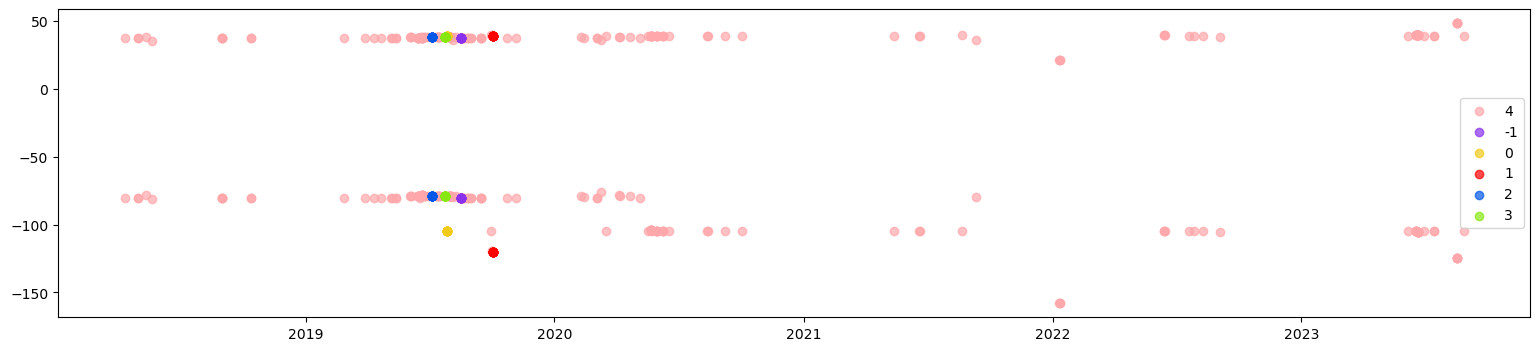

In [26]:
# Graphing lat/lon against observation times with colors assigned to clusters
plt.figure(figsize=(19, 4))

# the labels assigned in the "Artif_Cluster" column
labels = np.sort(rand_user_df["Artif_Cluster"].unique())

for i in labels: 
    # creates a subset for each cluster (or noncluster of -1)
    subset = rand_user_df[rand_user_df["Artif_Cluster"] == i]
    # Create a scatter plot for each subset with the corresponding color and label--one for lat and one for lon
    plt.scatter(subset["time_observed_at"], subset["latitude"], c=class_colors[i], label=labels[i], alpha = 0.7)
    plt.scatter(subset["time_observed_at"], subset["longitude"], c=class_colors[i], alpha = 0.7)


plt.legend()
plt.show()

Looks like all of the users spurts of several observations in a day happened in 2019. You can see the corresponding lat/lon happening for each cluster.

## Exploratory DBSCAN
Initial look at how DBSCAN performs compared to the baseline analytics model depending on the features chosen for analyzing. No concern for hyperparameters yet. 

### Continuous Time-Related Columns

In [27]:
# continuous columns only

init_db_col = ['id', 'latitude',
       'longitude', 'minute_diff', 'km_diff',
       'obs_time_conv_(minutes)', 'created_at_conv_(minutes)']
init_db_df = rand_user_df[init_db_col]


In [28]:
# use MinMaxScaler to give better meaning to the eps value
# and make distances smaller to compute

mms = MinMaxScaler()
init_db_df_mms = mms.fit_transform(init_db_df)


In [29]:
dbscan_model_01 = DBSCAN(eps=.1, min_samples=5)

# Fit and get labels
cluster_labels_01 = dbscan_model_01.fit_predict(init_db_df_mms)

In [30]:
len(np.unique(cluster_labels_01)) - 1

7

In [31]:
rand_user_df["Cluster_Label"] = cluster_labels_01
rand_user_df.sample(3)

C:\Users\lisa_\AppData\Local\Temp\ipykernel_49448\1953031401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_user_df["Cluster_Label"] = cluster_labels_01


,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,image_url,...,obs_year,obs_month,obs_day,obs_hour,created_year,created_month,created_day,created_hour,Artif_Cluster,Cluster_Label
44,28244468,Fri Jul 05 2019 10:51:44 GMT-0400 (EDT),2019-07-05,2019-07-05 14:51:44+00:00,Eastern Time (US & Canada),923056,2019-07-05 18:41:54+00:00,needs_id,https://www.inaturalist.org/observations/28244468,https://static.inaturalist.org/photos/44015235...,...,2019.0,51.0,5.0,14.0,2019.0,41.0,5.0,18.0,3,1
197,128070849,2022-07-26 09:07:02-06:00,2022-07-26,2022-07-26 15:07:02+00:00,Mountain Time (US & Canada),923056,2022-07-26 23:38:14+00:00,research,https://www.inaturalist.org/observations/12807...,https://static.inaturalist.org/photos/21750392...,...,2022.0,7.0,26.0,15.0,2022.0,38.0,26.0,23.0,-1,5
101,29936841,Wed Jul 31 2019 13:02:04 GMT-0400 (EDT),2019-07-31,2019-07-31 17:02:04+00:00,Eastern Time (US & Canada),923056,2019-07-31 20:08:38+00:00,needs_id,https://www.inaturalist.org/observations/29936841,https://static.inaturalist.org/photos/46748108...,...,2019.0,2.0,31.0,17.0,2019.0,8.0,31.0,20.0,-1,1


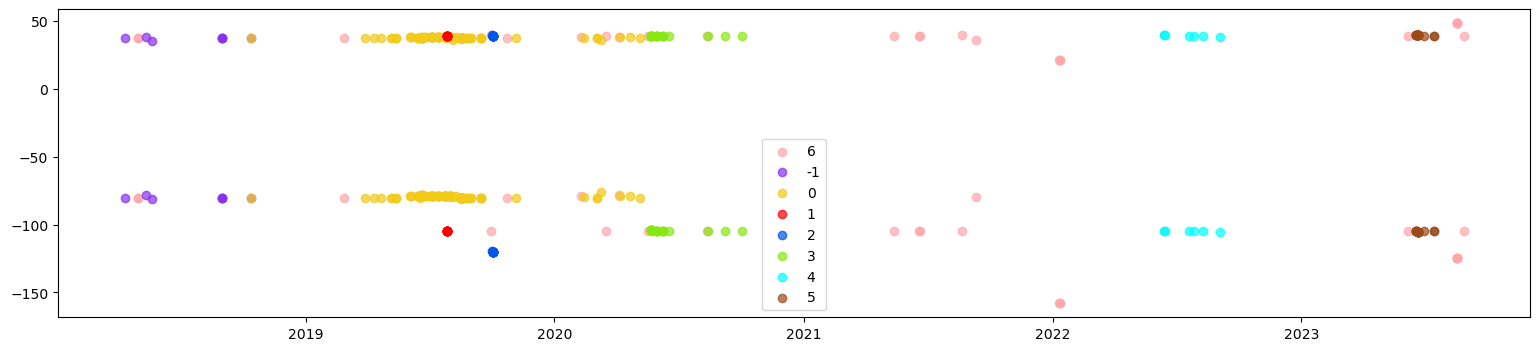

In [32]:
plt.figure(figsize=(19, 4))

labels = np.sort(rand_user_df["Cluster_Label"].unique())


for i in labels: 
    subset = rand_user_df[rand_user_df["Cluster_Label"] == i]
    # Create a scatter plot for each class with the corresponding color and label
    plt.scatter(subset["time_observed_at"], subset["latitude"], c=class_colors[i], label=labels[i], alpha = 0.7)
    plt.scatter(subset["time_observed_at"], subset["longitude"], c=class_colors[i], alpha = 0.7)


plt.legend()
plt.show()

In [33]:
# silhouette score of baseline non-ML model using the same columns as db_01 used

non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]

artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()
init_db_df_array = non_noise[init_db_col].to_numpy()

silhouette_score(init_db_df_array, artificial_cluster_array)

0.9886512196271166

In [34]:
# silhouette score of dbscan_model_01 (using unscaled data to compare to above)

cluster_labels = dbscan_model_01.fit_predict(init_db_df_mms)
    
silhouette_score(init_db_df[cluster_labels != -1], cluster_labels[cluster_labels != -1])


-0.06573911735458776

Continuous on its own seems to finds the "big clusters" -- when this user was active vs. inactive (although what is happening with Cluster 6 is confusing). Also performs signficantly worse on silhouette score than my model (although, in fairness, it seemed to be "focused" on some other kind of grouping, so not sure the two numbers are worth comparing). 

### Discrete Time Columns

In [35]:
db_df_2 = rand_user_df[['latitude', 'longitude', 'obs_month', 'obs_day', 'obs_hour', 'obs_year',
       'created_year', 'created_month', 'created_day', 'created_hour']]

In [36]:
mms = MinMaxScaler()
db_df_2_mms = mms.fit_transform(db_df_2)

dbscan_model_02 = DBSCAN(eps=.1, min_samples=5)

# Fit and get labels
cluster_labels_02 = dbscan_model_02.fit_predict(db_df_2_mms)

In [37]:
len(np.unique(cluster_labels_02)) - 1

4

In [38]:
rand_user_df["Cluster_Label"] = cluster_labels_02


C:\Users\lisa_\AppData\Local\Temp\ipykernel_49448\2790669217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_user_df["Cluster_Label"] = cluster_labels_02


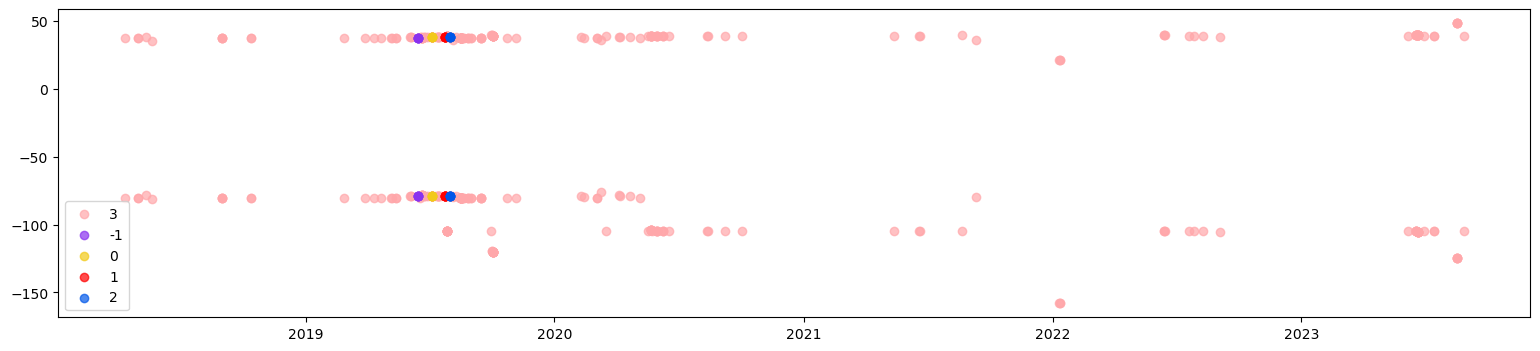

In [39]:
plt.figure(figsize=(19, 4))

labels = np.sort(rand_user_df["Cluster_Label"].unique())


for i in labels: 
    subset = rand_user_df[rand_user_df["Cluster_Label"] == i]
    # Create a scatter plot for each class with the corresponding color and label
    plt.scatter(subset["time_observed_at"], subset["latitude"], c=class_colors[i], label=labels[i], alpha = 0.7)
    plt.scatter(subset["time_observed_at"], subset["longitude"], c=class_colors[i], alpha = 0.7)


plt.legend()
plt.show()

In [40]:
# silhouette score of baseline non-ML model using the same columns as db_02 used
# next two lines defined in previous block but commented out here in case

#non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
#artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()

db_df_2_array = non_noise[db_df_2.columns].to_numpy()

silhouette_score(db_df_2_array, artificial_cluster_array)

0.3101741894625671

In [41]:
# silhouette score of dbscan_model_02 on unscaled data for comparison
    
silhouette_score(db_df_2[cluster_labels_02 != -1], cluster_labels_02[cluster_labels_02 != -1])

0.8811594423641622

OK Discrete columns seem to do well here--it only found 4 clusters but likely pretty solid "hikes". Will be curious to drill into that more closely to what it found.

### Combo Time Columns


In [42]:
# chose four features from each
db_df_3 = rand_user_df[['id', 'latitude',
       'longitude', 'minute_diff', 'km_diff',
       'obs_time_conv_(minutes)', 'obs_year',
       'obs_month', 'obs_day', 'obs_hour']]

In [43]:
mms = MinMaxScaler()
db_df_3_mms = mms.fit_transform(db_df_3)

dbscan_model_03 = DBSCAN(eps=.1, min_samples=5)

# Fit and get labels
cluster_labels_03 = dbscan_model_03.fit_predict(db_df_3_mms)

In [44]:
len(np.unique(cluster_labels_03)) - 1

6

In [45]:
rand_user_df["Cluster_Label"] = cluster_labels_03

C:\Users\lisa_\AppData\Local\Temp\ipykernel_49448\1988594208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_user_df["Cluster_Label"] = cluster_labels_03


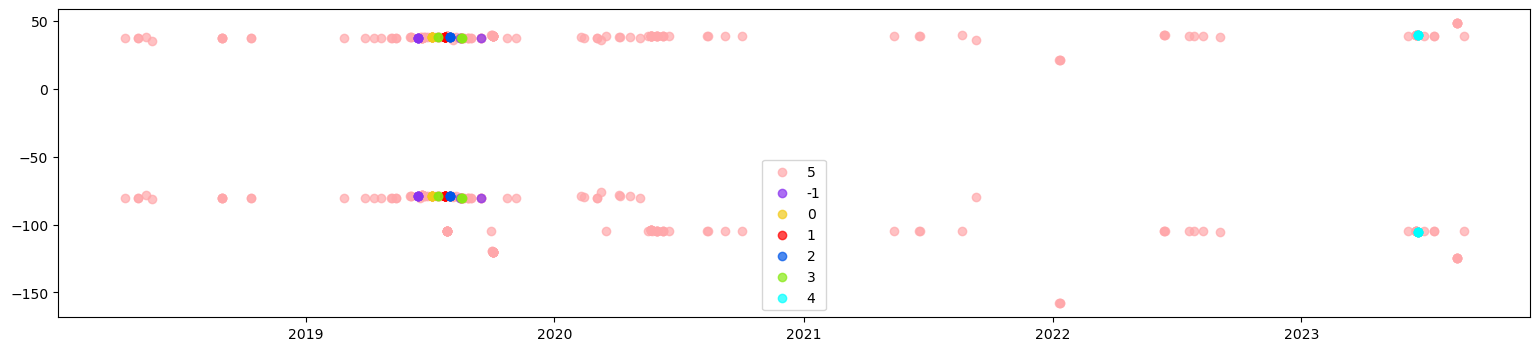

In [46]:
plt.figure(figsize=(19, 4))

labels = np.sort(rand_user_df["Cluster_Label"].unique())


for i in labels: 
    subset = rand_user_df[rand_user_df["Cluster_Label"] == i]
    # Create a scatter plot for each class with the corresponding color and label
    plt.scatter(subset["time_observed_at"], subset["latitude"], c=class_colors[i], label=labels[i], alpha = 0.7)
    plt.scatter(subset["time_observed_at"], subset["longitude"], c=class_colors[i], alpha = 0.7)


plt.legend()
plt.show()

In [47]:
# silhouette score of baseline non-ML model using the same columns as db_03 used
# next two lines defined in previous block but commented out here in case

#non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
#artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()

db_df_3_array = non_noise[db_df_3.columns].to_numpy()

silhouette_score(db_df_3_array, artificial_cluster_array)

0.9886465098647974

In [48]:
# silhouette score of dbscan_model_03 on unscaled data for comparison
    
silhouette_score(db_df_3[cluster_labels_03 != -1], cluster_labels_03[cluster_labels_03 != -1])

0.5817549122501475

This found 6 groups--so more like my own model, but the score is much worse. (And my score is best on this set of features--not sure what to make of that). Regardless, it looks like we need the discrete times to help the model. Not sure if we need the continuous times. 

## Optimizing Stage 1

### Feature Selection
Testing different sets of time- and distance- related features against each other. 

First I'm creating a function df_feat_sel() for choosing a slice of the user-specific dataframe based on feature selections. This way I can put the function in an optimization loop.

In [49]:
# Part of a help function for df_feat_sel

def feat_sel_param(i):
    '''
    Takes an integer and returns the feature selection information.
    Meant to be used as part of 'help' for using the feat_sel function
    as a way of knowing what features each integer is associated with.
    
    Arguments:
    i -- integer 0 to 6 acting as keys in the dictionary for the feature selections
    
    Returns:
    Tuple with first element a string that acts as a descriptive title of the selected features
    and second element a list of the column headings for features chosen for that description
    
    '''
    # Creating the dictionary for feature selection
    # feature_sel_options dictionary should match that of df_feat_sel() function
    feature_sel_options = {}

    feature_sel_options[0] = ("continuous_heavy", 
                              ['id', 'latitude', 'longitude', 
                               'minute_diff', 'km_diff', 
                               'obs_time_conv_(minutes)', 'created_at_conv_(minutes)'])

    feature_sel_options[1] = ("continuous_light",
                              ['latitude','longitude', 
                               'km_diff','obs_time_conv_(minutes)'])

    feature_sel_options[2] = ("discrete_heavy",
                              ['latitude', 'longitude', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year',
                               'created_year', 'created_month', 'created_day', 'created_hour'])

    feature_sel_options[3] = ("discrete_light",
                              ['latitude', 'longitude', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year'])

    # including this one to imitate the features I used for my own baseline model
    feature_sel_options[4] = ("discrete_barebones",
                              ['obs_month', 'obs_day', 'obs_year'])

    feature_sel_options[5] = ("combo_heavy", 
                              ['id', 'latitude', 'longitude', 
                               'minute_diff', 'km_diff', 
                               'obs_time_conv_(minutes)', 'created_at_conv_(minutes)', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year', 
                               'created_year', 'created_month', 'created_day', 'created_hour'])

    feature_sel_options[6] = ("combo_light", 
                              ['latitude', 'longitude', 
                               'minute_diff', 'km_diff', 
                               'obs_time_conv_(minutes)',  
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year'])
    
    # returns feature selection values if i is appropriate/exists as key
    # (also allowing user to also save and access the column lists without the df_feat_sel feature)
    if i in range(len(feature_sel_options)):
        return feature_sel_options[i]
    # but prints helpful info if i is not a dictionary key
    else:
        print(f'Input needs to be an integer between 0 and {len(feature_sel_options) - 1}')



In [50]:
def df_feat_sel(df, i):
    
    '''
    Takes a user-specific dataframe (df) and an integer mapped to a specific set of features
    and returns a dataframe for cluster analysis. 
    
    Arguments:
    df -- name of user-specific dataframe from the df_sp dataframe (after discrete time columns have been added)
    i -- integer 0 to 6 acting as keys in the dictionary for the feature selections
    
    For a reminder of what i maps to, use feat_sel_param() function
    
    Returns:
    Dataframe slice of original dataframe with only the columns chosen for feature selection
    
    '''
    
    sel_df = df[feat_sel_param(i)[1]]
   

    return sel_df

### Feature and Hyperparameter Optimization

In [74]:

#non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
#artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()
    
#empty dataframe for analysis of silhouette scores
sil_scores = pd.DataFrame()
index = 0 # indexing unit for dataframe

# i loops through the different feature selections
for i in range(7):
    # create slice of dataframe for modeling with feature_code
    subset = df_feat_sel(rand_user_df, i)
    
    # calc silhouette for baseline with this same set of col
    baseline_array = non_noise[subset.columns].to_numpy()
    baseline_sil = silhouette_score(baseline_array, artificial_cluster_array)
    
    # scale data --choosing MinMaxScaler to make it easier to guess at good values for DBSCAN eps
    mms = MinMaxScaler()
    subset_scaled = mms.fit_transform(subset)
    
    # looping through choices for eps and min_samples for DBSCAN
    for e in [.01, .05, .1, .25, .5, .75, .9]:
        for m in [3, 4, 5, 6, 7, 8, 9, 10]:
            #instantiate model
            dbscan_model = DBSCAN(eps=e, min_samples=m)
            # Fit and get labels
            cluster_labels = dbscan_model.fit_predict(subset_scaled)
            num_clusters = len(np.unique(cluster_labels))
            
            # silhouette scores require at least two groups to analyze and I'm excluding "noise"
            # from the scoring so the num_clusters needs to be 3 or more
            if num_clusters > 2:
                db_sil = silhouette_score(subset[cluster_labels != -1], cluster_labels[cluster_labels != -1])
            else: 
                db_sil = np.NaN


            # store info in analysis dataframe
            sil_scores.loc[index, "feature_code"] = i
            sil_scores.loc[index, "eps"] = e
            sil_scores.loc[index, "min_samples"] = m
            sil_scores.loc[index, "baseline_silhouette"] = baseline_sil
            sil_scores.loc[index, "db_silhouette"] = db_sil
            index += 1

In [76]:
# Overview of set for not null scores
sil_scores[sil_scores["db_silhouette"].notnull()].describe()

,feature_code,eps,min_samples,baseline_silhouette,db_silhouette
count,169.000000,169.000000,169.000000,169.000000,169.000000
mean,2.668639,0.218994,6.023669,0.706557,0.322887
std,2.069397,0.192711,2.275524,0.378273,0.354742
min,0.000000,0.010000,3.000000,-0.009295,-0.432920
25%,1.000000,0.050000,4.000000,0.310174,0.012273
50%,2.000000,0.250000,6.000000,0.978888,0.308712
75%,5.000000,0.250000,8.000000,0.988646,0.584847
max,6.000000,0.750000,10.000000,0.988651,0.999973


Describe table shows there are times dbscan outperforms my baseline model

In [82]:
# What do the top scores look like?
sil_scores[sil_scores["db_silhouette"]>0.98].sort_values(by = "db_silhouette")


,feature_code,eps,min_samples,baseline_silhouette,db_silhouette
288,5.0,0.05,3.0,0.988646,0.995872
298,5.0,0.10,5.0,0.988646,0.998746
297,5.0,0.10,4.0,0.988646,0.998954
299,5.0,0.10,6.0,0.988646,0.999092
289,5.0,0.05,4.0,0.988646,0.999973


Overwhelmingly, feature_code 5 shows up as best performance among top performing. To get more specific, it seems that 0.1 for eps does well and small min_samples (between 3 and 6)

In [73]:
# Reminder of what feature selection is #5
feat_sel_param(5)

('combo_heavy',
 ['id',
  'latitude',
  'longitude',
  'minute_diff',
  'km_diff',
  'obs_time_conv_(minutes)',
  'created_at_conv_(minutes)',
  'obs_month',
  'obs_day',
  'obs_hour',
  'obs_year',
  'created_year',
  'created_month',
  'created_day',
  'created_hour'])